In [1]:
import numpy as np
import numpy.random as npr
from scipy.stats import norm
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from keras import backend as kb
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
mu = 0.1
sigma = 0.5
steps = 100
S0 = 1
n = 100000
K = 1
epochs = 10

In [3]:
def BlackScholes(S0,r,sigma,T,K):
    d1 =  1 / (sigma * np.sqrt(T)) * (np.log(S0/K) + (r+sigma**2/2)*T)
    d2 = d1 - sigma * np.sqrt(T)
    return norm.cdf(d1) * S0 - norm.cdf(d2) * K * np.exp(-r*T)
callprice = BlackScholes(S0,0,sigma,1,K)
def BlackScholesCallDelta(S0,r,sigma,T,K):
    d1 =  1 / (sigma * np.sqrt(T)) * (np.log(S0/K) + (r+sigma**2/2)*T)
    return norm.cdf(d1)

In [4]:
xi = npr.normal(0,np.sqrt(1/steps),(n,steps))
W = np.apply_along_axis(np.cumsum,1,xi)
W = np.concatenate((np.zeros((n,1)),W),1)
drift = np.linspace(0,mu,steps+1)
drift = np.reshape(drift,(1,steps+1))
drift = np.repeat(drift,n,axis=0)
S = S0 * np.exp(drift + sigma * W)
dS = np.diff(S,1,1)
tim = np.linspace(0,1,steps+1)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [11]:
tSinput = []
for i in range(steps):
    timv = np.repeat(tim[i],n)
    timv = np.reshape(timv,(n,1))
    Sv = np.reshape(S[:,i],(n,1))
    tSinput.append(np.concatenate((timv,Sv),1))

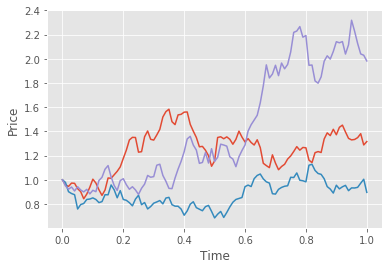

In [12]:
plt.plot(tim,S[0],tim,S[1],tim,S[2])
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [ ]:
def loss_call(y_true,y_pred):
    return (callprice + kb.sum(y_pred * y_true,axis=-1) - kb.maximum(S0 + kb.sum(y_true,axis=-1) - K,0.))**2

inputs = []
predictions = []

layer1 = Dense(100, activation='relu')
layer2 = Dense(100, activation='relu')
layer3 = Dense(100, activation='relu')
layer4 = Dense(1, activation='sigmoid')

for i in range(steps):
    sinput = Input(shape=(2,))
    x = layer1(sinput)
    x = layer2(x)
    x = layer3(x)
    sprediction = layer4(x)
    inputs.append(sinput)
    predictions.append(sprediction)
    
predictions = Concatenate(axis=-1)(predictions)
model = Model(inputs=inputs, outputs=predictions)
model.summary()
model.compile(optimizer='adam', loss=loss_call, metrics=[])

In [ ]:
model.fit(tSinput,dS,batch_size=100,epochs=epochs)

Epoch 1/10
100000/100000 [==============================] - 20s 197us/step - loss: 0.0016
Epoch 2/10
100000/100000 [==============================] - 22s 222us/step - loss: 3.5799e-04
Epoch 3/10
100000/100000 [==============================] - 22s 220us/step - loss: 3.3789e-04
Epoch 4/10
100000/100000 [==============================] - 21s 214us/step - loss: 3.3025e-04
Epoch 5/10
100000/100000 [==============================] - 7812s 78ms/step - loss: 3.2691e-04
Epoch 6/10
100000/100000 [==============================] - 22s 216us/step - loss: 3.2778e-04
Epoch 7/10
100000/100000 [==============================] - 22s 218us/step - loss: 3.1905e-04
Epoch 8/10
 26400/100000 [======>.......................] - ETA: 15s - loss: 3.1832e-04

/home/ppl/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


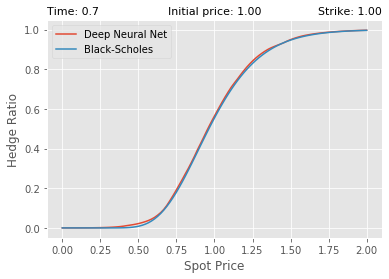

In [12]:
time = 0.7
tStest = []
Sval = np.linspace(0,2,num=steps)
for i in range(steps):
    z = (time,Sval[i])
    z = np.reshape(z,(1,2))
    tStest.append(z)

    
    
Delta_learn = np.reshape(model.predict(tStest),(steps,))
Delta_BS = BlackScholesCallDelta(Sval,0,sigma,1-time,K)
line_learn = plt.plot(Sval,Delta_learn,label="Deep Neural Net")
line_BS = plt.plot(Sval,Delta_BS, label="Black-Scholes")
plt.xlabel("Spot Price")
plt.ylabel("Hedge Ratio")
plt.title(r'Time: %1.1f' % time, loc='left', fontsize=11)
plt.title(r'Strike: %1.2f' % K, loc='right', fontsize=11)
plt.title(r'Initial price: %1.2f' % S0, loc='center', fontsize=11)
plt.legend()
#plt.show()
#plt.savefig("deephedge.png", dpi=150)
plt.savefig("deephedge.pdf")